In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib

2025-09-15 00:36:35.218280: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-15 00:36:35.219141: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 00:36:35.302046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 00:36:37.362814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
df = pd.read_csv('../data/CSPX_feature_engineered.csv', parse_dates=['Date'])
df.head()

,Date,Close,High,Low,Open,Volume,MA5,MA20,Return,MA50,Volatility20,Year,Month,Day,Lag1,Lag2,Lag3
0,2019-03-12,274.179993,274.540009,272.829987,273.839996,60269.0,271.404004,272.340501,0.007163,263.6052,0.006188,2019,3,12,272.230011,268.029999,270.040009
1,2019-03-13,276.070007,276.500000,273.779999,273.790009,94606.0,272.110004,272.678001,0.006893,264.2286,0.006306,2019,3,13,274.179993,272.230011,268.029999
2,2019-03-14,275.899994,276.760010,275.190002,276.200012,41365.0,273.282001,273.051001,-0.000616,264.9206,0.006234,2019,3,14,276.070007,274.179993,272.230011
3,2019-03-15,277.480011,277.640015,275.829987,276.089996,70838.0,275.172003,273.363002,0.005727,265.5474,0.005957,2019,3,15,275.899994,276.070007,274.179993
4,2019-03-18,277.279999,278.309998,277.119995,277.320007,33259.0,276.182001,273.619502,-0.000721,266.1078,0.005948,2019,3,18,277.480011,275.899994,276.070007


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1465 non-null   datetime64[ns]
 1   Close         1465 non-null   float64       
 2   High          1465 non-null   float64       
 3   Low           1465 non-null   float64       
 4   Open          1465 non-null   float64       
 5   Volume        1465 non-null   float64       
 6   MA5           1465 non-null   float64       
 7   MA20          1465 non-null   float64       
 8   Return        1465 non-null   float64       
 9   MA50          1465 non-null   float64       
 10  Volatility20  1465 non-null   float64       
 11  Year          1465 non-null   int64         
 12  Month         1465 non-null   int64         
 13  Day           1465 non-null   int64         
 14  Lag1          1465 non-null   float64       
 15  Lag2          1465 non-null   float64 

In [4]:
SEQ_LEN = 60           # look-back window (days)
TEST_SIZE = 0.2        # fraction for test set
EPOCHS = 15
BATCH_SIZE = 32
LSTM_UNITS = 50
PATIENCE = 3
SEED = 42

In [5]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

- You want to predict tomorrow’s (next-day) Close price.
- But your features (High, Low, Open, Volume, etc.) are all from today.
- If you directly set Target = df['Close'], then the model would just learn to "predict today’s close using today’s features" → which is cheating (because you already know today’s close).

In [6]:
df['Target'] = df['Close'].shift(-1)

In [7]:
df = df.dropna().reset_index(drop=True)

# encode month as a cyclical feature (sine/cosine transform), not as raw integers 1–12. Otherwise, the model thinks “December (12) is far from January (1),” which is wrong.

In [8]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)

- Date → not a numeric feature, just an index for plotting → drop.
- Year → not useful for short-term stock prediction (can confuse the model).
- Day → raw day of month isn’t predictive → drop

In [9]:
X = df.drop(columns=['Date', 'Year', 'Day', 'Month', 'Target'])
y = df['Target']

In [10]:
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Target scaler
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [ ]:
X_scaled.shape, y_scaled.shape

((1464, 15), (1464, 1))

# LSTM is a sequence model
- LSTM (Long Short-Term Memory) is designed to learn patterns over time.
- Stock prices are time-dependent: today’s price depends on past days, not just current features.
- If you feed only one row at a time, the LSTM cannot see trends, momentum, or volatility over previous days.

# For the LSTM input at day 61:
- X → data from day 1 to 60
- y → Target for day 61 (Close[61])
- This way, the model learns patterns over the past 60 days to predict tomorrow.

# Logic / Reasoning
- Stock prices are sequential → today’s features are influenced by past days.
- Capturing trends → moving averages, volatility, and lag features alone aren’t enough; sequence lets LSTM learn temporal dependencies.
- Forecasting → by creating sequences, the model can predict the next day based on historical context, which is what we want for time series forecasting.

In [12]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])  # past SEQ_LEN days
        ys.append(y[i])            # target = next day
    return np.array(Xs), np.array(ys)

In [13]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)
print(X_seq.shape, y_seq.shape)

(1404, 60, 15) (1404, 1)


# Why time-based split
- Stock data is sequential — yesterday influences today.
- If you randomly shuffle, future data could leak into training → unrealistically high performance.

In [14]:
n_samples = len(X_seq)
train_size = int(n_samples * (1 - TEST_SIZE))

X_train = X_seq[:train_size]
X_test  = X_seq[train_size:]

y_train = y_seq[:train_size]
y_test  = y_seq[train_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1123, 60, 15) (1123, 1)
Test shape: (281, 60, 15) (281, 1)


# Dates for plotting
- If you want to plot predictions later, keep the dates aligned:

In [15]:
dates_seq = df['Date'][SEQ_LEN:].reset_index(drop=True)
dates_test = dates_seq[train_size:].reset_index(drop=True)

In [16]:
dates_seq

0      2019-06-10
1      2019-06-11
2      2019-06-12
3      2019-06-13
4      2019-06-14
          ...    
1399   2024-12-19
1400   2024-12-20
1401   2024-12-23
1402   2024-12-24
1403   2024-12-27
Name: Date, Length: 1404, dtype: datetime64[ns]

# Design choices for CPU-friendly model:
- 1 LSTM layer with 50 units → small enough for CPU, still captures temporal patterns
- Dropout 0.2 → prevent overfitting
- Dense(1) → output next-day Close
- Adam optimizer, MSE loss → standard for regression

In [17]:
model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


E0000 00:00:1757867799.153696    7157 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757867799.157237    7157 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/chinung/.pyenv/versions/lewagon/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0444 - val_loss: 0.0049
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


# model is learning well → both decrease and stabilize.

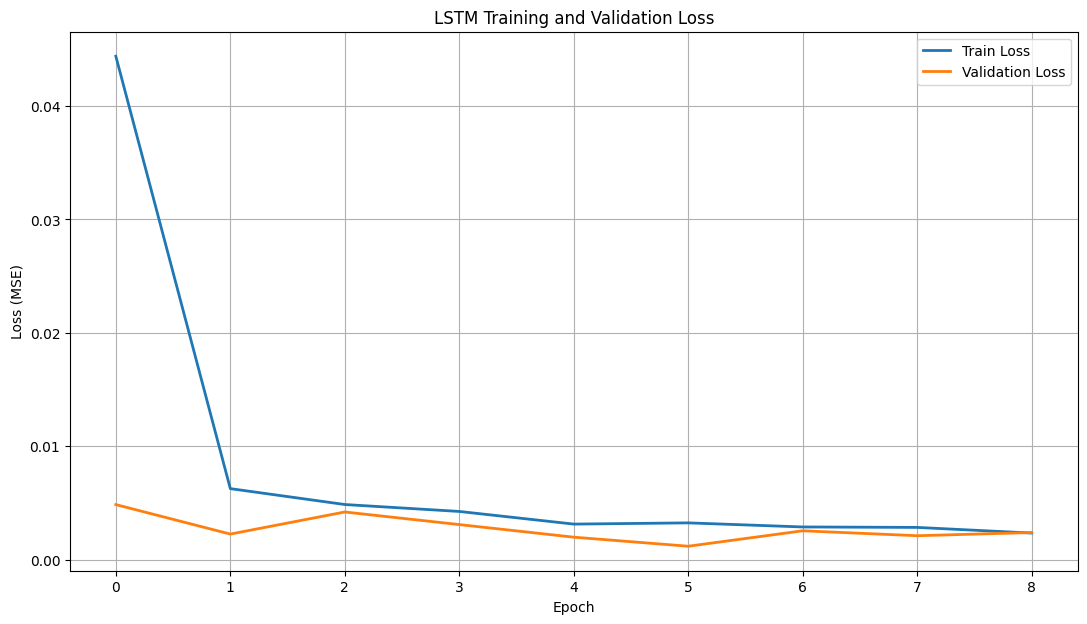

In [19]:
plt.figure(figsize=(13,7))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_inv = target_scaler.inverse_transform(y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [21]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"LSTM results -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

LSTM results -> RMSE: 14.566, MAE: 12.593, R2: 0.903


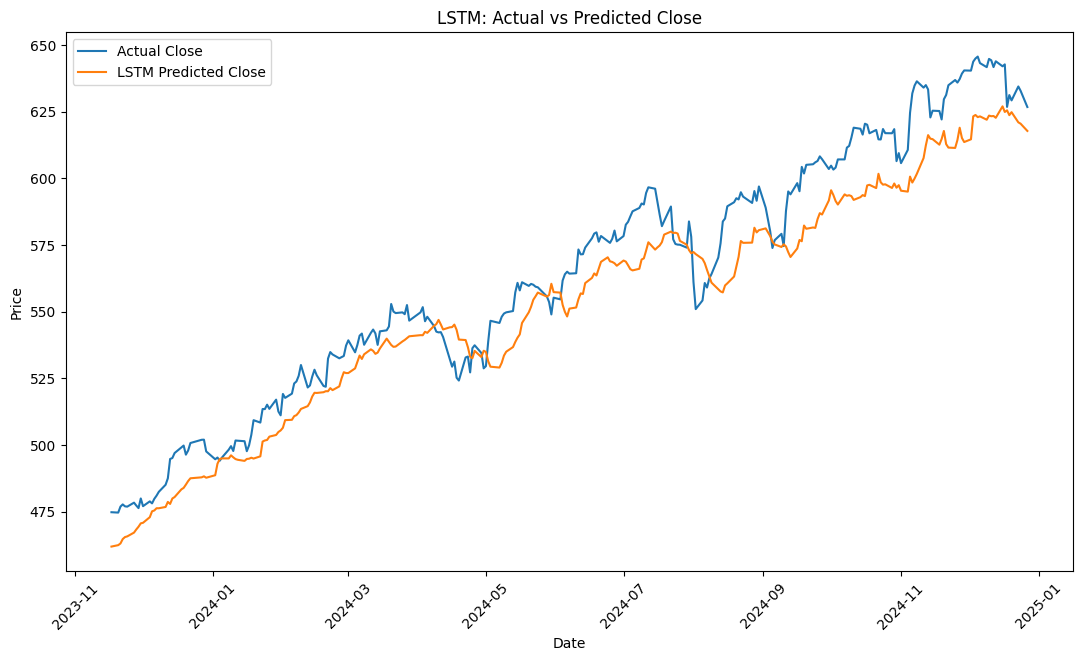

In [22]:
plt.figure(figsize=(13,7))
plt.plot(dates_test, y_test_inv.flatten(), label='Actual Close')
plt.plot(dates_test, y_pred.flatten(), label='LSTM Predicted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Actual vs Predicted Close')
plt.legend()
plt.xticks(rotation=45)
plt.show()

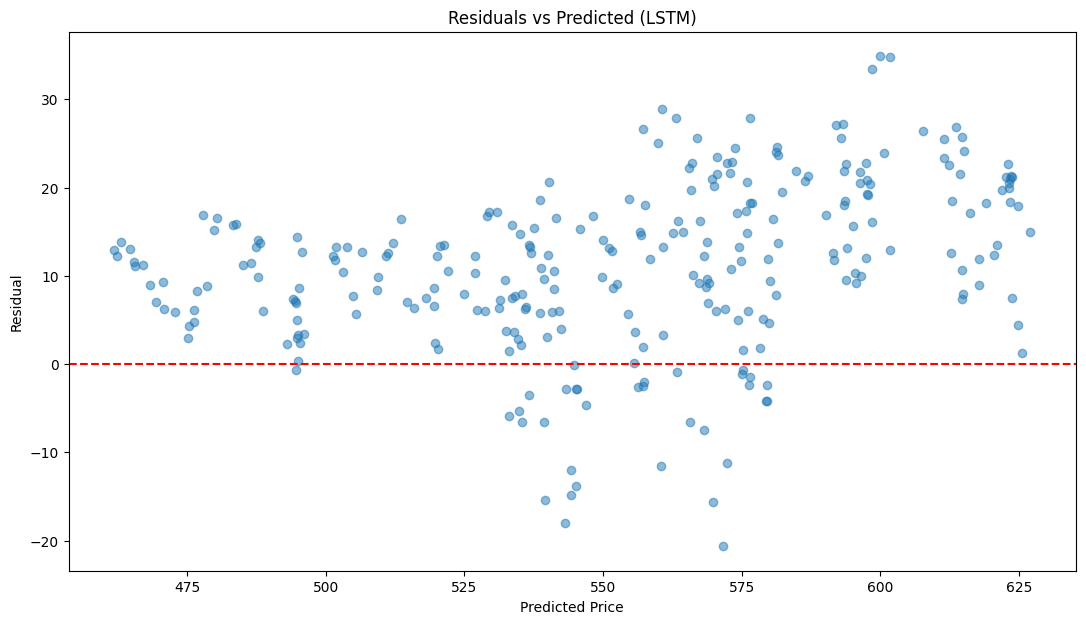

In [23]:
residuals = y_test_inv - y_pred

# Scatter plot residuals
plt.figure(figsize=(13,7))
plt.scatter(y_pred.flatten(), residuals.flatten(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted (LSTM)')
plt.show()

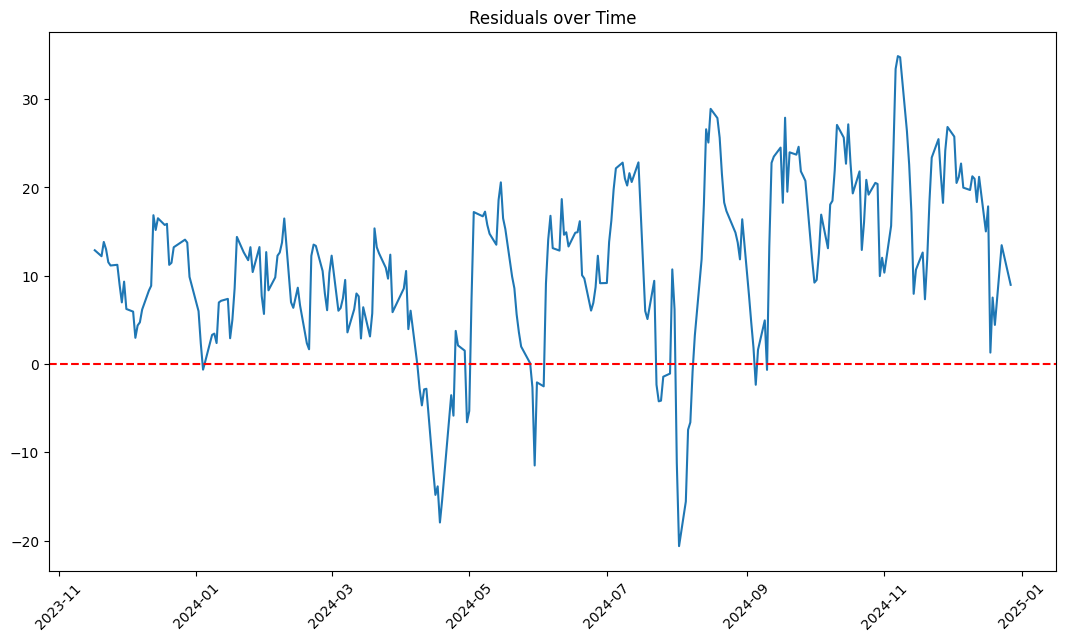

In [24]:
# Residuals over time
plt.figure(figsize=(13,7))
plt.plot(dates_test, residuals.flatten())
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals over Time')
plt.xticks(rotation=45)
plt.show()

# LSTM is working and significantly better than XGBoost for CSPX next-day prediction.

In [33]:
len(X.columns)

15

In [26]:
importances = {}

# --- Permute one feature at a time ---
for i, feature_name in enumerate(X.columns):  # use real column names
    X_permuted = X_test.copy()
    np.random.shuffle(X_permuted[:, :, i])  # shuffle this feature across time

    y_pred_perm = model.predict(X_permuted)
    y_pred_perm_inv = target_scaler.inverse_transform(y_pred_perm)

    rmse_perm = np.sqrt(mean_squared_error(y_test_inv, y_pred_perm_inv))
    importances[feature_name] = rmse_perm - rmse

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [27]:
importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
print("Permutation Importances:")
for k, v in importances.items():
    print(f"{k}: RMSE increase {v:.2f}")

Permutation Importances:
High: RMSE increase 7.28
Lag1: RMSE increase 6.76
Close: RMSE increase 4.21
Lag3: RMSE increase 2.07
MA20: RMSE increase 1.96
MA50: RMSE increase 1.75
Open: RMSE increase 1.60
Low: RMSE increase 0.56
MA5: RMSE increase 0.37
Volume: RMSE increase 0.02
Volatility20: RMSE increase 0.01
Month_cos: RMSE increase -0.02
Return: RMSE increase -0.13
Month_sin: RMSE increase -0.35
Lag2: RMSE increase -0.36


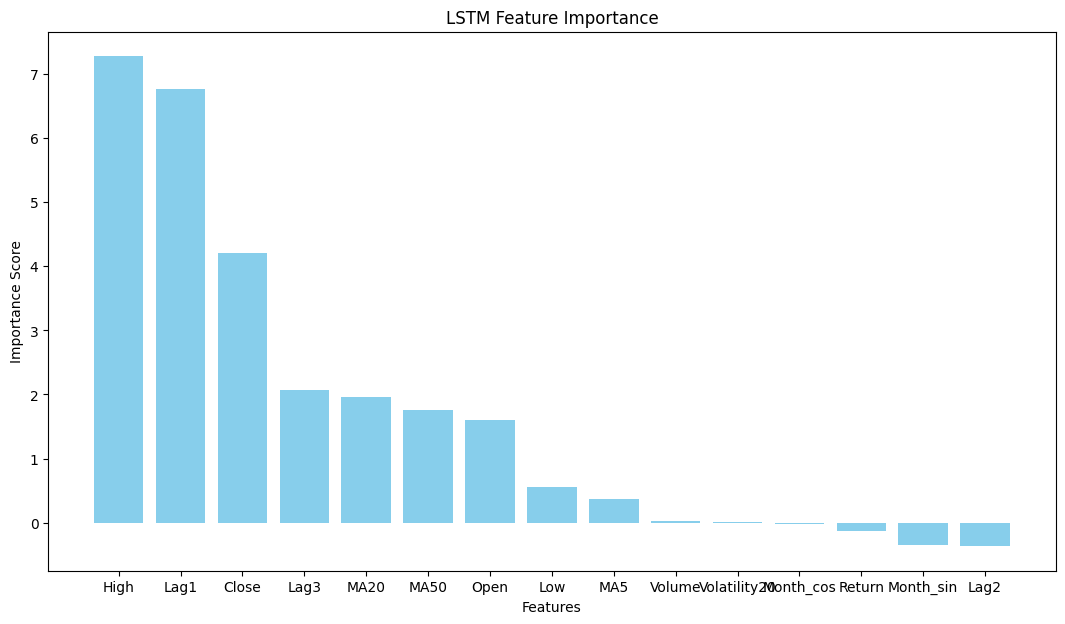

In [28]:
features = list(importances.keys())
scores = list(importances.values())

# Bar chart
plt.figure(figsize=(13,7))
plt.bar(features, scores, color="skyblue")
plt.title("LSTM Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

In [ ]:
model.save("lstm_model.h5")

In [32]:
# feature_scaler: fitted on X_train
joblib.dump(feature_scaler, "feature_scaler.pkl")

# # target_scaler: fitted on y_train
joblib.dump(target_scaler, "target_scaler.pkl")

['target_scaler.pkl']